## Data Loading

In [1]:
import polars as pl

df_dsa = pl.read_ipc("data/Beer_Analyzer_Data_full.feather")
df_nir = pl.read_ipc("data/Fermentation_NIR_absorbance_full.feather")

df_dsa = df_dsa.with_columns(
    pl.col('BatchName').cast(pl.Utf8)
)

Number of spectra and samples from the individual batches

In [2]:
counts_spectra = df_nir["BatchName"].value_counts().sort("BatchName")
counts_samples = df_dsa["BatchName"].value_counts().sort("BatchName")

counts = counts_spectra.join(counts_samples, on="BatchName")
counts = counts.rename({"count": "n_spectra", "count_right": "n_samples"})

counts

BatchName,n_spectra,n_samples
str,u32,u32
"""01_Zwickelbier""",7084,14
"""02_Zwickelbier""",6597,15
"""03_Zwickelbier""",10659,16
"""04_Wiener_Lager""",6128,14
"""05_European_Red_Lager""",6473,16
"""06_Uni_Pils""",6371,16


## Outlier detection

C:\Users\Admin\Documents\Repositories\NIR-Beer-Fermentation-Monitoring\NIRBeer\visualization.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 1])


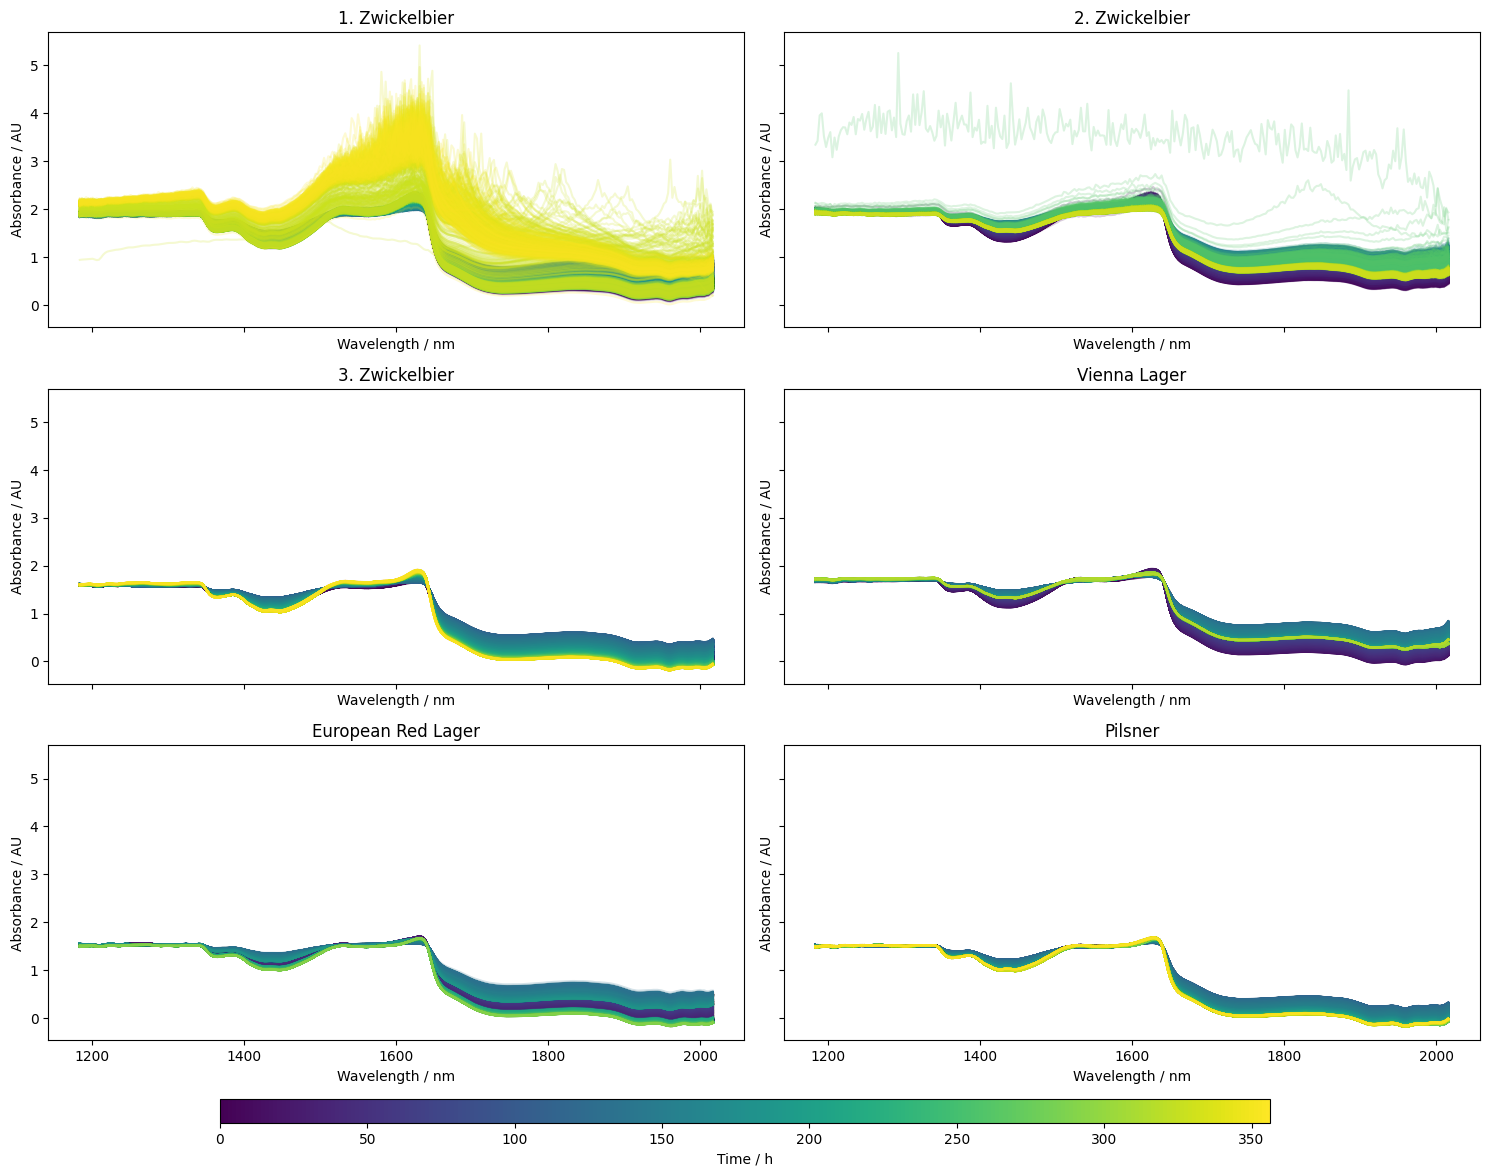

In [3]:
from NIRBeer.visualization import plot_spectra_by_batch
from sklearn.pipeline import Pipeline
from chemotools.feature_selection import RangeCut
import numpy as np

batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]
wavelengths = np.linspace(1100, 2100, 359)
preprocessing = Pipeline([
    ('range_cut', RangeCut(30, -30)),
])

plot_spectra_by_batch(df_nir, wavelengths, batch_names=batch_names, preprocessing=preprocessing, n_cols=2, output_filename="figures/spectra_by_batch.png")

In [4]:
from NIRBeer.outlier_detection import detect_outliers
from chemotools.feature_selection import RangeCut

preprocessing = Pipeline([("range_cut", RangeCut(30, -30))])

result = detect_outliers(df_nir, alpha=0.05, var_threshold=0.95, preprocessing=preprocessing)

print("Removed", df_nir.shape[0] - result.num_inliers, "outliers")

Removed 1250 outliers


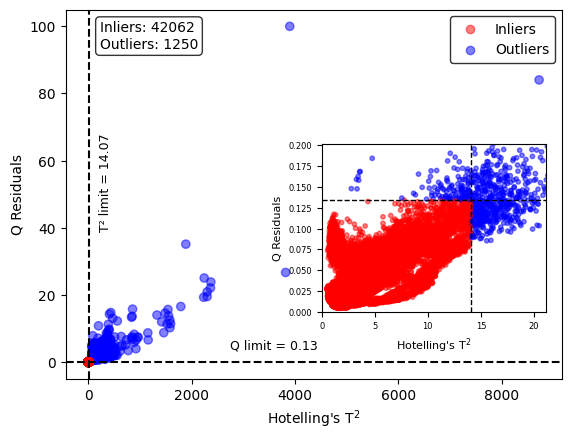

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
scatter = plt.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5)   
plt.axvline(result.t2_limit, color="black", ls="--")
plt.axhline(result.q_limit, color="black", ls="--")
plt.xlabel("Hotelling's T$^2$")
plt.ylabel("Q Residuals") 

# Add text labels for the limit lines on the main plot
plt.text(200, plt.ylim()[1] * 0.65, f'T² limit = {result.t2_limit:.2f}', 
         ha='left', va='top', rotation=90, fontsize=9, backgroundcolor='white')
plt.text(plt.xlim()[1] * 0.3, 3, f'Q limit = {result.q_limit:.2f}', 
         ha='left', va='bottom', rotation=0, fontsize=9, backgroundcolor='white')

# Calculate inliers and outliers counts
inliers_count = np.sum(result.inliers_mask)
outliers_count = np.sum(~result.inliers_mask)
total_count = len(result.inliers_mask)

# Add textbox with counts in upper right corner
textstr = f'Inliers: {inliers_count}\nOutliers: {outliers_count}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(225, plt.ylim()[1] * 0.9675, textstr, fontsize=10,
         va='top', ha='left', bbox=props)

# Add legend with scatter markers
plt.scatter([], [], c='red', alpha=0.5, label='Inliers')
plt.scatter([], [], c='blue', alpha=0.5, label='Outliers')
plt.legend(edgecolor='black', fancybox=True, framealpha=0.8)  # Moved legend to lower left to avoid overlap

# Create inset axes in the right bottom corner
inset_ax = plt.axes([0.525, 0.25, 0.35, 0.35])  # [left, bottom, width, height]

# Plot the same data on the inset axes (without text labels)
inset_ax.scatter(result.t2, result.q, c=result.inliers_mask, cmap="bwr", alpha=0.5, s=10)
inset_ax.axvline(result.t2_limit, color="black", ls="--", linewidth=1)
inset_ax.axhline(result.q_limit, color="black", ls="--", linewidth=1)

# Set the limits for the zoomed-in region
inset_ax.set_xlim(0, result.t2_limit * 1.5)
inset_ax.set_ylim(0, result.q_limit * 1.5)

# Add labels to inset (optional)
inset_ax.set_xlabel("Hotelling's T$^2$", fontsize=8)
inset_ax.set_ylabel("Q Residuals", fontsize=8)
inset_ax.tick_params(labelsize=6)
plt.savefig("figures/detected_outliers.jpg", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\Admin\Documents\Repositories\NIR-Beer-Fermentation-Monitoring\NIRBeer\visualization.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 1])


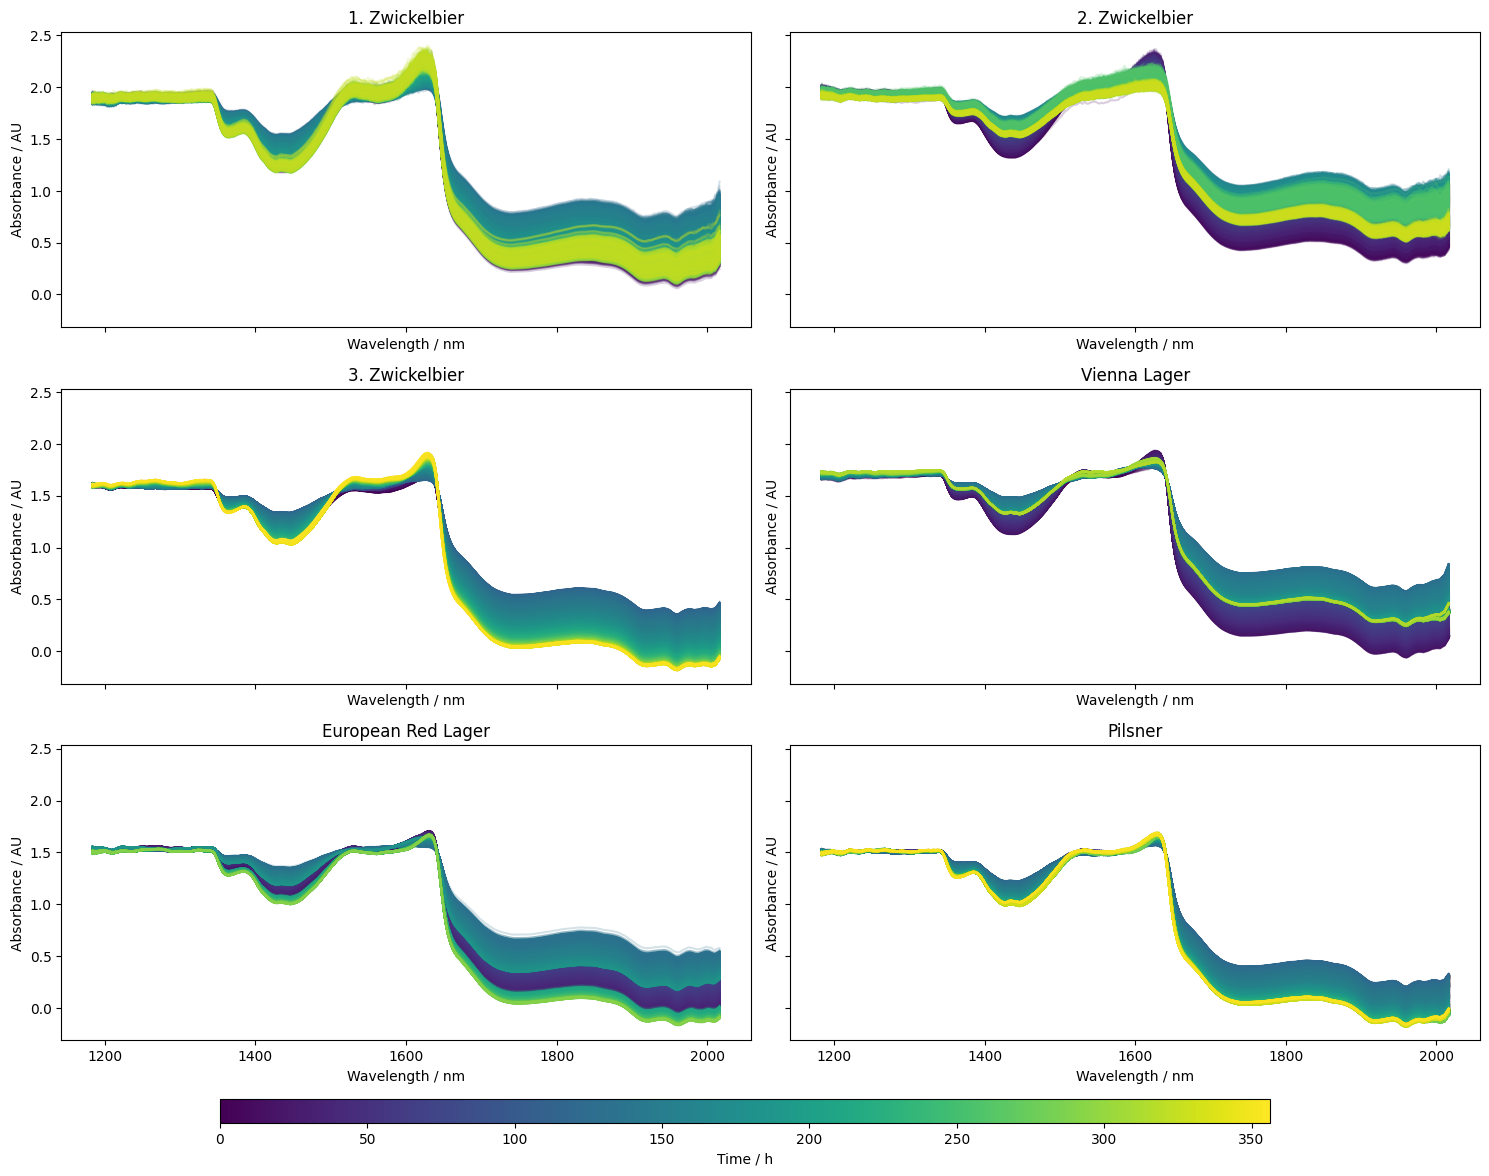

In [8]:
from NIRBeer.visualization import plot_spectra_by_batch
from sklearn.pipeline import Pipeline
from chemotools.feature_selection import RangeCut
import numpy as np

df_nir_clean = result.df_inliers
batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]
wavelengths = np.linspace(1100, 2100, 359)
preprocessing = Pipeline([
    ('range_cut', RangeCut(30, -30)),
])

plot_spectra_by_batch(df_nir_clean, wavelengths, batch_names=batch_names, preprocessing=preprocessing, n_cols=2, output_filename="figures/spectra_by_batch_outliers_removed.png")

## Data sampling

In [79]:
from NIRBeer.interpolation import interpolate_targets_to_spectra
from NIRBeer.sampling import adaptive_time_sampler

df_interpolate = interpolate_targets_to_spectra(result.df_inliers, df_dsa)

min_time = 3 
max_time = 16
k_rate = 50
exponent = 3 / 2

selected_df = df_interpolate.group_by("BatchName", maintain_order=True).map_groups(
    lambda df_group: adaptive_time_sampler(
        df_group,
        min_dt=min_time,
        max_dt=max_time,
        rate_k=k_rate,
        exp_val=exponent
    )
)

selected_df

TimeStamp,CumulativeTime,BatchName,WL1,WL2,WL3,WL4,WL5,WL6,WL7,WL8,WL9,WL10,WL11,WL12,WL13,WL14,WL15,WL16,WL17,WL18,WL19,WL20,WL21,WL22,WL23,WL24,WL25,WL26,WL27,WL28,WL29,WL30,WL31,WL32,WL33,WL34,…,WL328,WL329,WL330,WL331,WL332,WL333,WL334,WL335,WL336,WL337,WL338,WL339,WL340,WL341,WL342,WL343,WL344,WL345,WL346,WL347,WL348,WL349,WL350,WL351,WL352,WL353,WL354,WL355,WL356,WL357,WL358,WL359,Ereal_interp,wtPercEtOH_interp,dE_dt,dEtOH_dt,derivative_magnitude
datetime[ns],f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-02-22 19:34:54,0.0,"""01_Zwickelbier""",1.34102,1.455327,1.610804,2.008538,1.230953,1.442495,1.560237,1.52893,1.970147,2.329023,1.857789,2.270877,1.884227,1.928454,1.641216,1.768077,1.695239,1.844475,1.802914,1.862269,1.850439,1.808025,1.888273,1.830387,1.861964,1.910703,1.942874,1.923817,1.893569,1.898796,1.920295,1.925785,1.906007,1.918798,…,0.593451,0.615416,0.63486,0.703287,0.723369,0.773006,0.719547,0.825228,0.872628,0.942904,1.164525,1.442099,1.06226,1.28133,1.540475,1.573968,1.826204,1.642156,1.96746,1.402441,1.600581,1.654735,1.778735,2.087338,1.587566,1.395971,1.807379,1.418881,1.351655,1.499288,2.065911,1.737227,12.638252,0.0,-0.022169,0.011476,0.024964
2024-02-22 22:34:54,3.0,"""01_Zwickelbier""",1.47729,2.035215,1.334794,1.277674,1.336624,1.088557,1.340754,1.400323,1.415206,1.801594,1.890915,1.981295,1.947995,1.921911,1.872315,1.742064,1.896704,1.748924,1.796447,1.873505,1.795125,1.861677,1.834649,1.851074,1.812075,1.862108,1.88566,1.90237,1.893361,1.885068,1.911733,1.892769,1.910751,1.870631,…,0.430913,0.476117,0.480774,0.537266,0.540895,0.562864,0.573051,0.646344,0.715873,0.755463,0.833864,0.941538,1.075456,1.096586,1.346405,1.432134,1.388659,1.621244,1.488149,1.47251,1.982442,1.493703,1.851939,1.572243,1.253544,2.054059,1.331484,1.883242,1.688692,1.48024,1.571386,1.632558,12.572443,0.034068,-0.021689,0.011228,0.024423
2024-02-23 01:34:54,6.0,"""01_Zwickelbier""",2.081734,2.238534,1.455909,1.391033,1.148758,1.102259,1.432668,1.438751,1.557895,1.53587,1.832581,1.806409,1.87349,1.709436,1.687723,1.68498,1.723421,1.765883,1.772831,1.766127,1.774186,1.857163,1.899982,1.828883,1.924495,1.8815,1.876232,1.875603,1.88285,1.889382,1.905743,1.866738,1.899148,1.882043,…,0.359657,0.391655,0.403742,0.460362,0.442006,0.456495,0.469999,0.548297,0.629911,0.667601,0.632564,0.818551,1.021776,1.095883,1.418614,1.302311,1.439484,1.408692,1.54963,1.326881,1.715066,1.62614,1.287148,1.988276,1.283086,1.522851,1.792946,1.577582,2.520643,1.41674,1.708162,1.830203,12.508199,0.067325,-0.021126,0.010936,0.023789
2024-02-23 04:34:54,9.0,"""01_Zwickelbier""",1.226923,1.214383,1.136417,1.061559,1.07986,1.069993,1.2796,1.085857,1.444159,1.460085,1.493604,1.538423,1.600252,1.706128,1.656623,1.693433,1.757809,1.700512,1.78516,1.67716,1.761213,1.754635,1.791975,1.829395,1.850386,1.886243,1.844801,1.843831,1.870569,1.887746,1.891509,1.87593,1.879056,1.892358,…,0.437101,0.490571,0.487711,0.532826,0.546863,0.546667,0.574401,0.677885,0.702806,0.736418,0.759419,0.956467,0.997781,1.1984,1.220629,1.686095,1.4727,2.674924,1.919846,1.803645,1.81344,1.756258,1.671983,1.417472,1.515153,2.134215,1.616983,1.43007,2.084077,1.900399,1.543966,1.6899,12.44577,0.099643,-0.020479,0.010602,0.023061
2024-02-23 07:37:55,12.050278,"""01_Zwickelbier""",1.35346,1.565774,1.271597,1.31207,1.067589,1.133478,1.185027,1.3137,1.483637,1.580551,1.824141,1.611254,1.966028,1.729254,1.676759,1.667361,1.935087,1.73114,1.736892,1.749945,1.783961,1.801491,1.873413,1.870341,1.855057,1.903125,1.903318,1.926653,1.916085,1.894562,1.880025,1.897547,1.910095,1.904278,…,0.48674,0.554752,0.565927,0.572053,0.624544,0.602621,0.593766,0.733428,0.773232,0.915357,0.934168,0.960279,1.082042,1.559668,2.424844,1.748202,1.768907,1.6889,1.714411,1.

In [6]:
selected_df.group_by("BatchName").len()

BatchName,len
str,u32
"""01_Zwickelbier""",74
"""02_Zwickelbier""",80
"""03_Zwickelbier""",86
"""04_Wiener_Lager""",71
"""05_European_Red_Lager""",64
"""06_Uni_Pils""",86


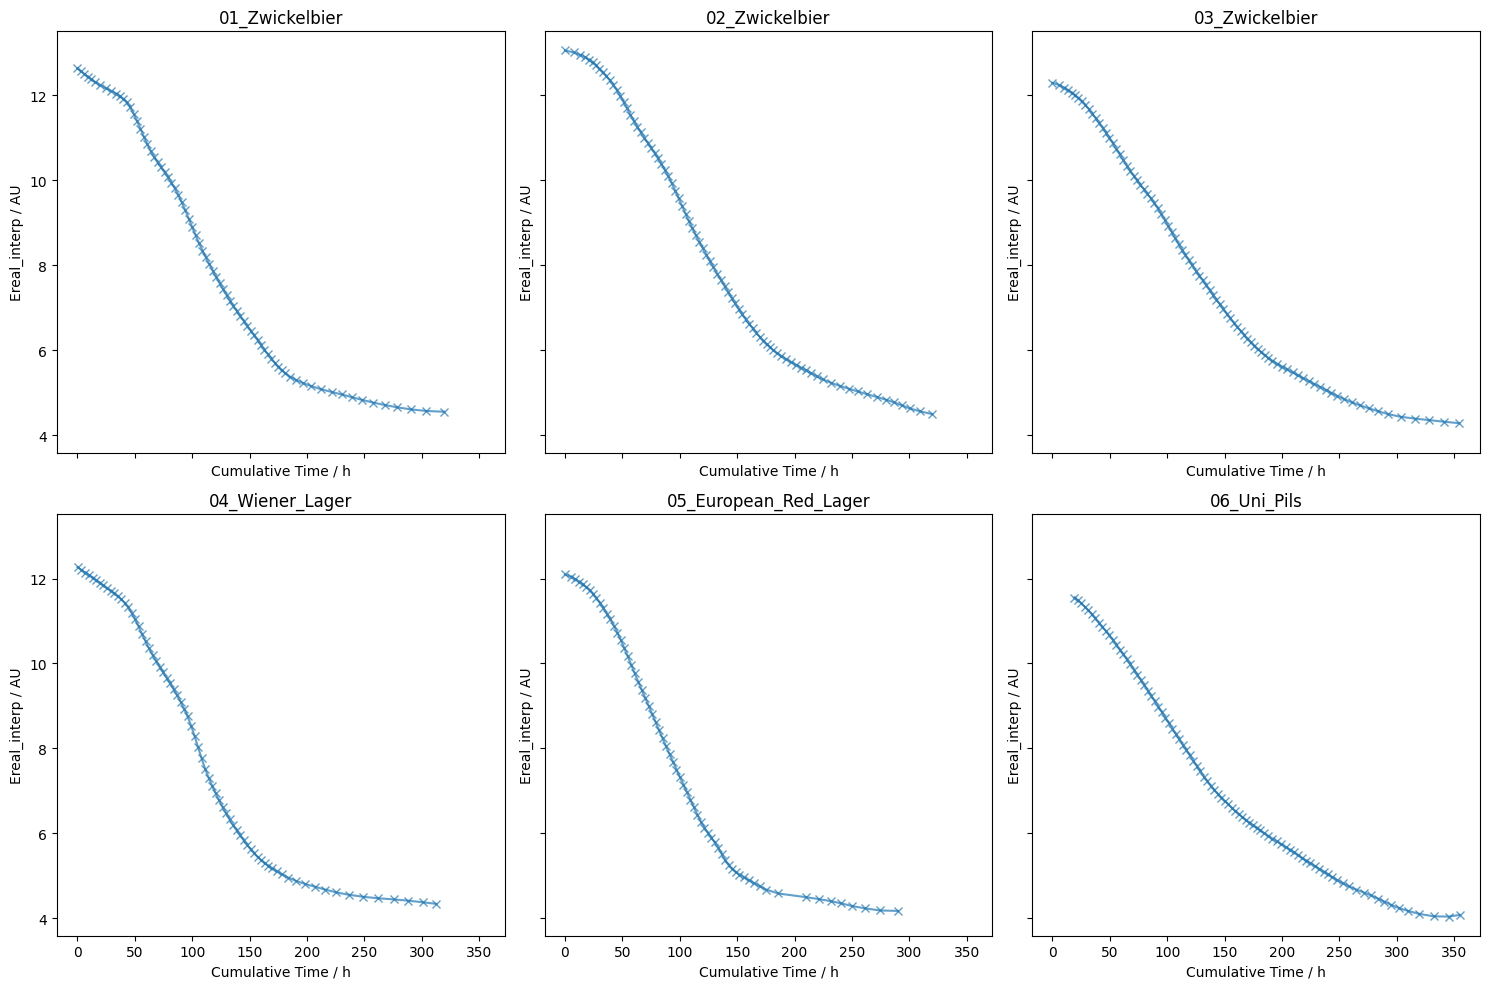

In [73]:
# Plot Ereal_interp vs CumulativeTime for all batches in a grid of subplots
import matplotlib.pyplot as plt
batches = selected_df["BatchName"].unique().sort().to_list()
n_batches = len(batches)
n_cols = 3
n_rows = int(np.ceil(n_batches / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
for i, batch in enumerate(batches):
    ax = axes[i // n_cols, i % n_cols]
    batch_data = selected_df.filter(pl.col("BatchName") == batch)
    ax.plot(batch_data["CumulativeTime"], batch_data["Ereal_interp"], marker='x', linestyle='-', alpha=0.7)
    ax.set_title(batch)
    ax.set_xlabel("Cumulative Time / h")
    ax.set_ylabel("Ereal_interp / AU")
plt.tight_layout()
#plt.savefig("selected_points.jpg", dpi=600, bbox_inches='tight')
plt.show()

## Grid-Search hyperparameter selection for PLS regression


--- Training Separate Model 1/2 ---
Starting GridSearchCV for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/PLS_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.1135, $R^2$: 0.9845
Holdout MSE for Ethanol: 0.0412, $R^2$: 0.9789

--- Training Separate Model 2/2 ---
Starting GridSearchCV for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/PLS_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.2451, $R^2$: 0.9539
Holdout MSE for Ethanol: 0.0291, $R^2$: 0.9794


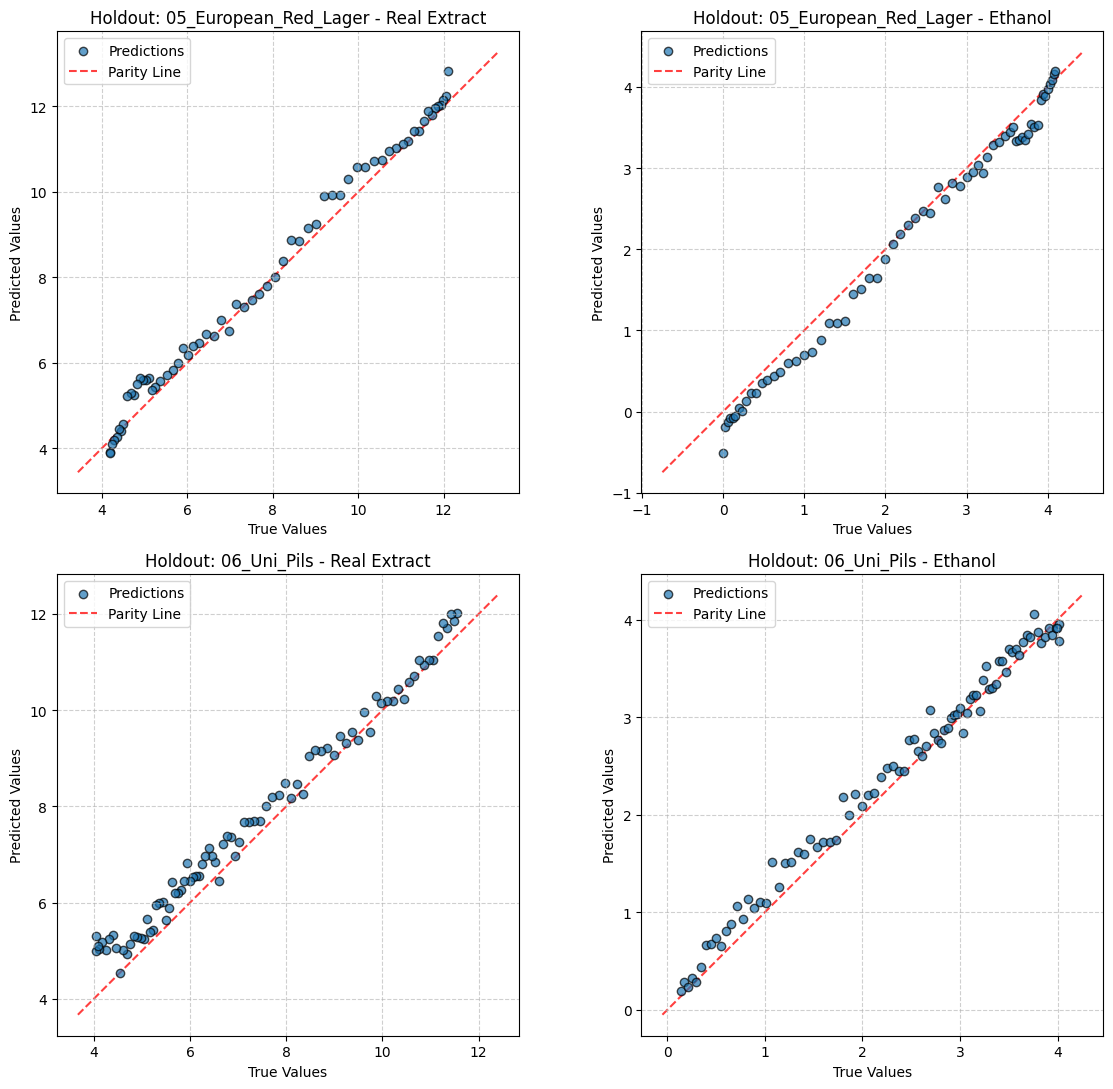

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__pls__n_components': np.int64(7),
   'regressor__sg__polynomial_order': np.int64(2),
   'regressor__sg__window_size': np.int64(11),
   'regressor__vip__vip_threshold': np.float64(0.8999999999999999)},
  'mse_real_extract': np.float64(0.11348741870696903),
  'r2_real_extract': 0.9845419780699182,
  'mse_ethanol': np.float64(0.041173185991653455),
  'r2_ethanol': 0.9789475997151286},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__pls__n_components': np.int64(7),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(18),
   'regressor__vip__vip_threshold': np.float64(1.4)},
  'mse_real_extract': np.float64(0.24505369549347866),
  'r2_real_extract': 0.9539181019848323,
  'mse_ethanol': np.float64(0.029071910501906086),
  'r2_ethanol': 0.9794173404133427}]

In [ ]:
from NIRBeer.model_training import train_and_evaluate
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay
from NIRBeer.feature_selection import VIPSelector
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        ('vip', VIPSelector(n_components_pls=3)),
        ('pls', PLSRegression(scale=False))
    ])

param_grid = {
        'regressor__pls__n_components': np.arange(3, 9),  # Example range of components to try
        'regressor__vip__vip_threshold': np.arange(0.5, 1.5, 0.1),  # Example thresholds to try
        'regressor__emsc__order': np.arange(1, 2),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

train_and_evaluate(df, holdout_batch, pipeline, f"models/PLS_gridsearch", param_grid=param_grid)

## Final PLS models


--- Training Separate Model 1/2 ---
Fitting model for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/PLS_final_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.1135, $R^2$: 0.9845
Holdout MSE for Ethanol: 0.0412, $R^2$: 0.9789

--- Training Separate Model 2/2 ---
Fitting model for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/PLS_final_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.0448, $R^2$: 0.9916
Holdout MSE for Ethanol: 0.0292, $R^2$: 0.9793


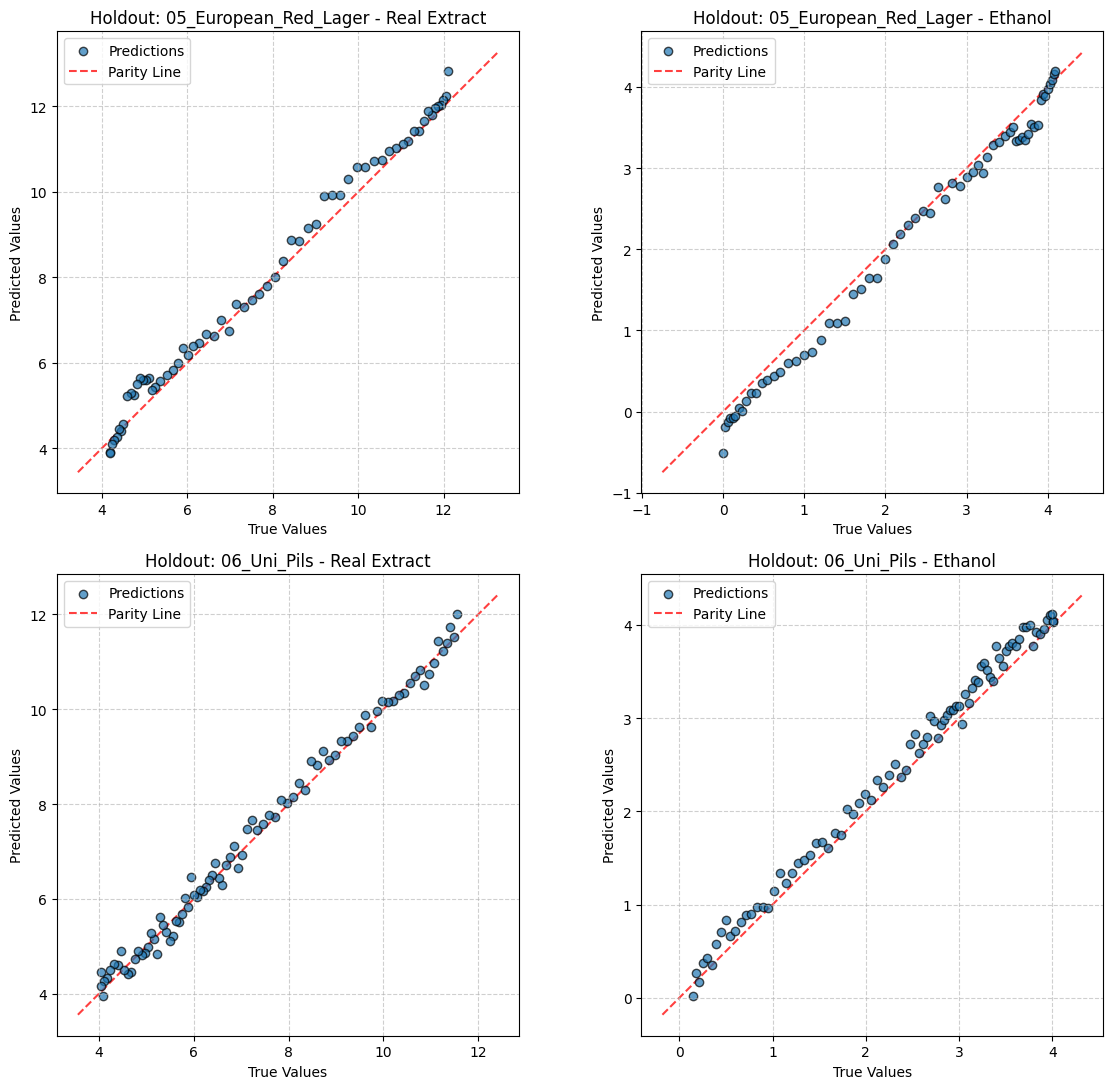

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.11348741870696903),
  'r2_real_extract': 0.9845419780699182,
  'mse_ethanol': np.float64(0.041173185991653455),
  'r2_ethanol': 0.9789475997151286},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.04479982929285681),
  'r2_real_extract': 0.9915754742632507,
  'mse_ethanol': np.float64(0.029184412914718377),
  'r2_ethanol': 0.9793376896843189}]

In [75]:
from NIRBeer.model_training import train_and_evaluate
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay
from NIRBeer.feature_selection import VIPSelector
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection(order=1)),
        ('sg', SavitzkyGolay(polynomial_order=2, window_size=11, derivate_order=1)),
        ('scaler', StandardScaler()),
        ('vip', VIPSelector(n_components_pls=3, vip_threshold=0.9)),
        ('pls', PLSRegression(n_components=7, scale=False))
    ])


train_and_evaluate(df, holdout_batch, pipeline, f"models/PLS_final", separate_models=True)

## Performance over course of fermentation
European Red Lager

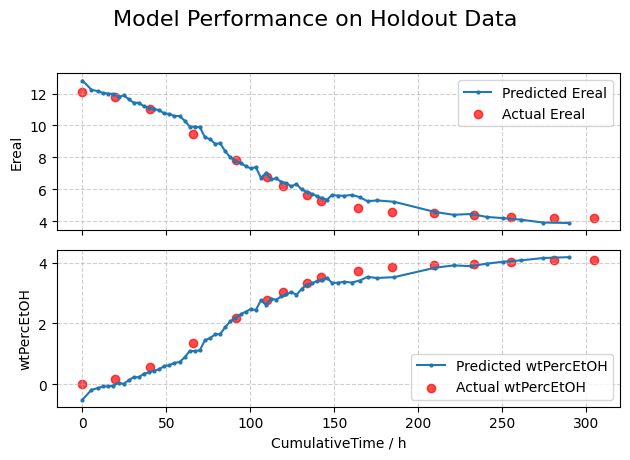

In [64]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/PLS_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

Uni Pils

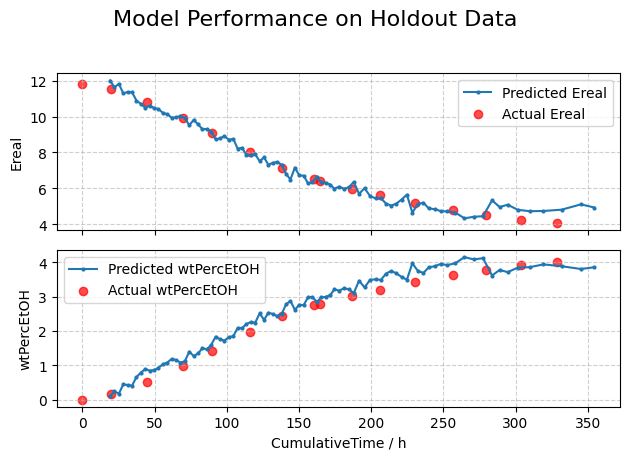

In [66]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "06_Uni_Pils"  # Change this to visualize different batches
best_model = joblib.load(f'models/PLS_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

## Grid-Search hyperparameter selection for MLP regression


--- Training Separate Model 1/2 ---
Starting GridSearchCV for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/MLP_gridsearch_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.0579, $R^2$: 0.9921
Holdout MSE for Ethanol: 0.0137, $R^2$: 0.9930

--- Training Separate Model 2/2 ---
Starting GridSearchCV for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/MLP_gridsearch_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.1520, $R^2$: 0.9714
Holdout MSE for Ethanol: 0.0169, $R^2$: 0.9880


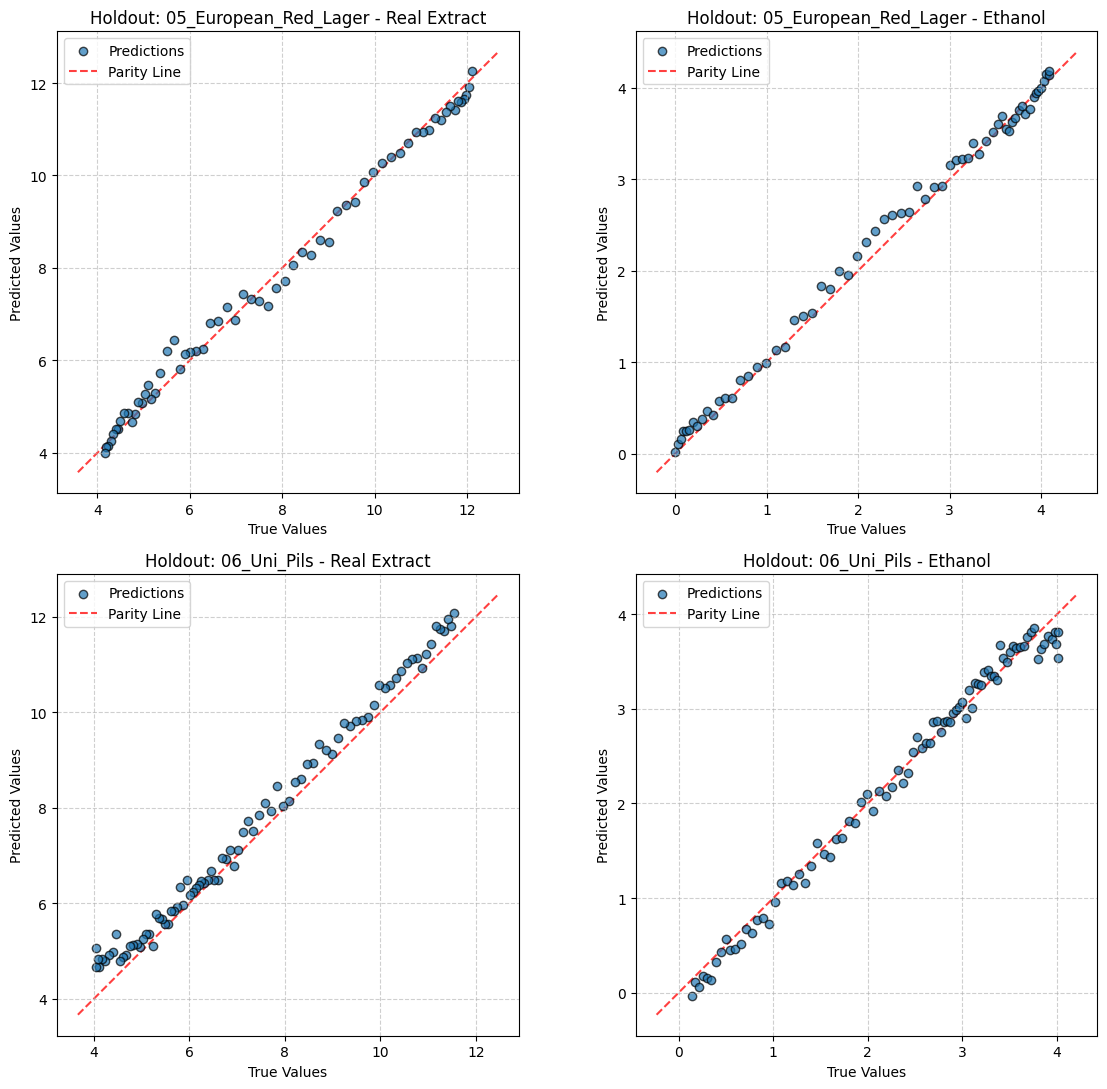

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__mlp__activation': 'tanh',
   'regressor__mlp__alpha': 10,
   'regressor__mlp__hidden_layer_sizes': (20,),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(18)},
  'mse_real_extract': np.float64(0.05789717111828706),
  'r2_real_extract': 0.9921138770179709,
  'mse_ethanol': np.float64(0.013656177390865101),
  'r2_ethanol': 0.9930174139826832},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__mlp__activation': 'tanh',
   'regressor__mlp__alpha': 10,
   'regressor__mlp__hidden_layer_sizes': (20,),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(19)},
  'mse_real_extract': np.float64(0.15198443424833705),
  'r2_real_extract': 0.9714196058752714,
  'mse_ethanol': np.float64(0.016897752511736332),
  'r2_ethanol': 0.9880365383036712}]

In [37]:
from NIRBeer.model_training import train_and_evaluate
from chemotools.feature_selection import RangeCut
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(random_state=42, max_iter=1500, early_stopping=True, n_iter_no_change=15))
 ])

param_grid = {
        'regressor__mlp__hidden_layer_sizes': [(20,), (30,), (40,)],  # Example hidden layer sizes
        'regressor__mlp__alpha': [0.1, 1, 10],  # Example regularization strengths
        'regressor__mlp__activation': ['relu', 'tanh'],  # Example activation functions
        'regressor__emsc__order': np.arange(1, 2),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

train_and_evaluate(df, holdout_batch, pipeline, f"models/MLP_gridsearch", separate_models=True, param_grid=param_grid)

## Final MLP models 


--- Training Separate Model 1/2 ---
Fitting model for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/MLP_final_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.0678, $R^2$: 0.9908
Holdout MSE for Ethanol: 0.0137, $R^2$: 0.9930

--- Training Separate Model 2/2 ---
Fitting model for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/MLP_final_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.1189, $R^2$: 0.9776
Holdout MSE for Ethanol: 0.0331, $R^2$: 0.9766


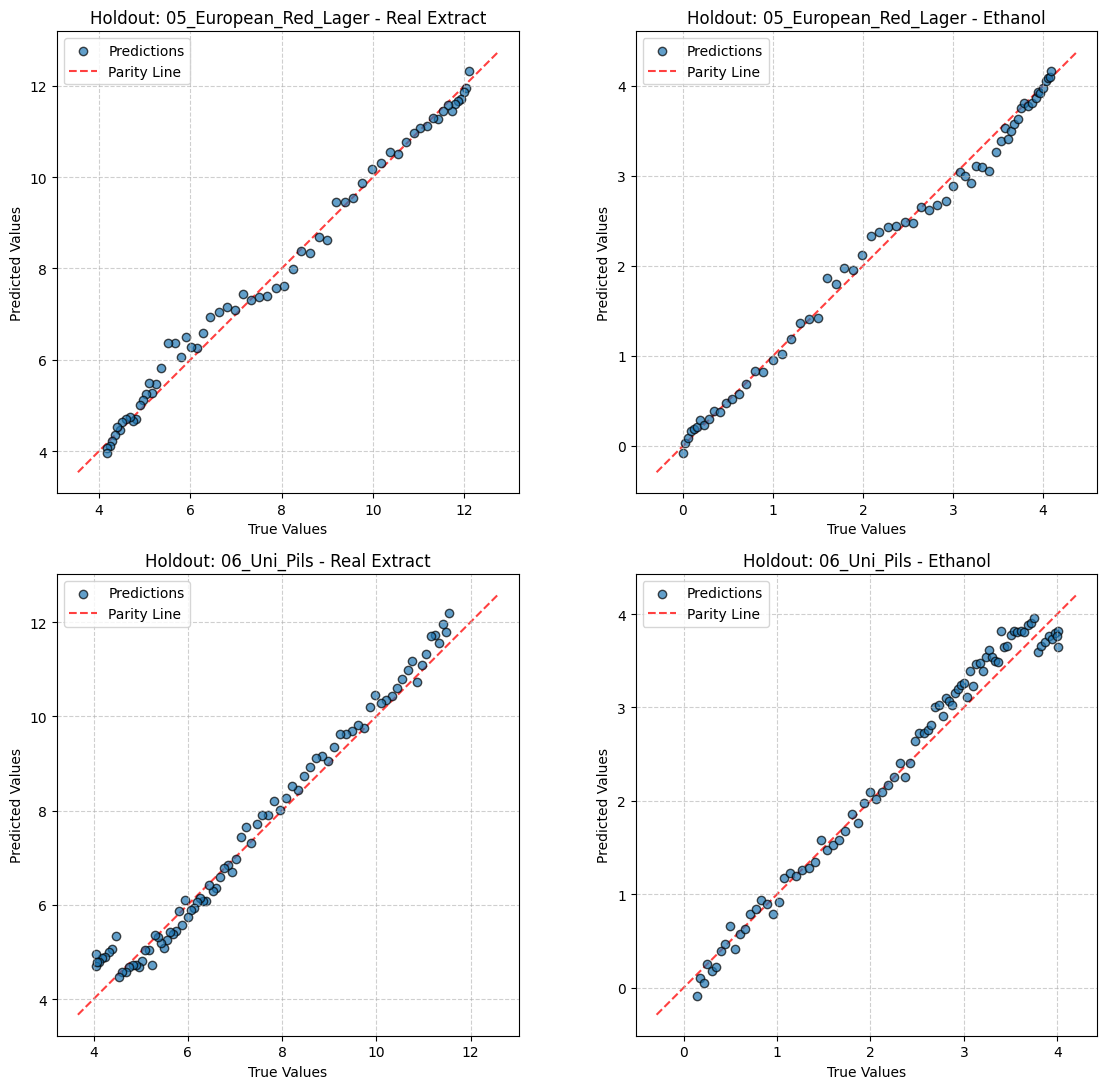

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.06781007488613468),
  'r2_real_extract': 0.9907636490757015,
  'mse_ethanol': np.float64(0.013666933079052245),
  'r2_ethanol': 0.9930119144555614},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.1188546289513758),
  'r2_real_extract': 0.9776496050021264,
  'mse_ethanol': np.float64(0.0330899142837895),
  'r2_ethanol': 0.9765726287094116}]

In [77]:
from NIRBeer.model_training import train_and_evaluate
from chemotools.feature_selection import RangeCut
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection(order=2)),
        ('sg', SavitzkyGolay(derivate_order=1, 
                             polynomial_order=3, 
                             window_size=16
                             )
        ),
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(random_state=42,
                             max_iter=1500, 
                             early_stopping=True, 
                             n_iter_no_change=15,
                             activation='tanh',
                             alpha=10,
                             hidden_layer_sizes=(20,)
                             )
        )
 ])


train_and_evaluate(df, holdout_batch, pipeline, f"models/MLP_final", separate_models=True)

## Performance over course of fermentation
European Red Lager

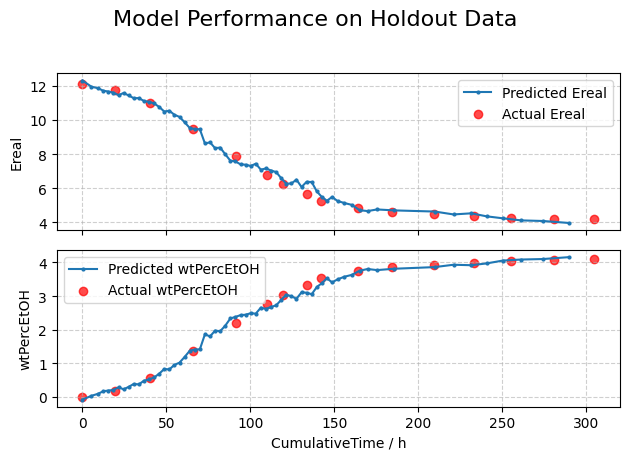

In [69]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/MLP_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

Uni Pils

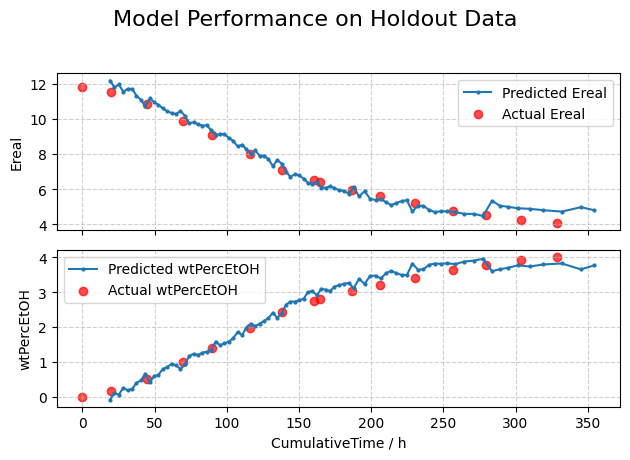

In [70]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "06_Uni_Pils"  # Change this to visualize different batches
best_model = joblib.load(f'models/MLP_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)